# Post-Training Quantization of OpenAI CLIP model with NNCF

The goal of this tutorial is to demonstrate how to speed up the model by applying 8-bit post-training quantization from [NNCF](https://github.com/openvinotoolkit/nncf/) (Neural Network Compression Framework) and infer quantized model via OpenVINO™ Toolkit. The optimization process contains the following steps:

1. Quantize the converted OpenVINO model from [notebook](228-clip-zero-shot-convert.ipynb) with NNCF.
2. Check the model result using the same input data from the [notebook](228-clip-zero-shot-convert.ipynb).
3. Compare model size of converted and quantized models.
4. Compare performance of converted and quantized models.

> **NOTE**: you should run [228-clip-zero-shot-convert](228-clip-zero-shot-convert.ipynb) notebook first to generate OpenVINO IR model that is used for quantization.

## Prerequisites

In [3]:
!pip install -q datasets
!pip install -q "git+https://github.com/openvinotoolkit/nncf.git@6c0aebadd2fcdbe1481a11b40b8cd9f66b3b6fab"

## Create and initialize quantization

[NNCF](https://github.com/openvinotoolkit/nncf/) enables post-training quantization by adding the quantization layers into the model graph and then using a subset of the training dataset to initialize the parameters of these additional quantization layers. The framework is designed so that modifications to your original training code are minor. Quantization is the simplest scenario and requires a few modifications.

The optimization process contains the following steps:
1. Create a Dataset for quantization.
2. Run `nncf.quantize` for getting a quantized model.
3. Serialize the `INT8` model using `openvino.runtime.serialize` function.

### Prepare datasets

The [Conceptual Captions](https://ai.google.com/research/ConceptualCaptions/) dataset consisting of ~3.3M images annotated with captions is used to quantize model.

In [4]:
import os

fp16_model_path = 'clip-vit-base-patch16.xml'
if not os.path.exists(fp16_model_path):
    raise RuntimeError('This notebook should be run after 228-clip-zero-shot-convert.ipynb.')

In [5]:
from transformers import CLIPProcessor, CLIPModel

model = CLIPModel.from_pretrained("openai/clip-vit-base-patch16")
max_length = model.config.text_config.max_position_embeddings
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch16")

In [6]:
import requests
from io import BytesIO
from PIL import Image
from requests.packages.urllib3.exceptions import InsecureRequestWarning
requests.packages.urllib3.disable_warnings(InsecureRequestWarning)

def check_text_data(data):
    """
    Check if the given data is text-based.
    """
    if isinstance(data, str):
        return True
    if isinstance(data, list):
        return all(isinstance(x, str) for x in data)
    return False

def get_pil_from_url(url):
    """
    Downloads and converts an image from a URL to a PIL Image object.
    """
    response = requests.get(url, verify=False, timeout=20)
    image = Image.open(BytesIO(response.content))
    return image.convert("RGB")

def collate_fn(example, image_column="image_url", text_column="caption"):
    """
    Preprocesses an example by loading and transforming image and text data.
    Checks if the text data in the example is valid by calling the `check_text_data` function.
    Downloads the image specified by the URL in the image_column by calling the `get_pil_from_url` function.
    If there is any error during the download process, returns None.
    Returns the preprocessed inputs with transformed image and text data.
    """
    assert len(example) == 1
    example = example[0]

    if not check_text_data(example[text_column]):
        raise ValueError("Text data is not valid")

    url = example[image_column]
    try:
        image = get_pil_from_url(url)
    except Exception:
        return None

    inputs = processor(text=example[text_column], images=[image], return_tensors="pt", padding=True)
    if inputs['input_ids'].shape[1] > max_length:
        return None
    return inputs

In [7]:
import torch
from datasets import load_dataset

def prepare_calibration_data(dataloader, init_steps):
    """
    This function prepares calibration data from a dataloader for a specified number of initialization steps.
    It iterates over the dataloader, fetching batches and storing the relevant data.
    """
    data = []
    print(f"Fetching {init_steps} for the initialization...")
    counter = 0
    for batch in dataloader:
        if counter == init_steps:
            break
        if batch:
            counter += 1
            with torch.no_grad():
                data.append(
                    {
                        "pixel_values": batch["pixel_values"].to("cpu"),
                        "input_ids": batch["input_ids"].to("cpu"),
                        "attention_mask": batch["attention_mask"].to("cpu")
                    }
                )
    return data


def prepare_dataset(opt_init_steps=300, max_train_samples=1000):
    """
    Prepares a vision-text dataset for quantization.
    """
    dataset = load_dataset("conceptual_captions", streaming=True)
    train_dataset = dataset["train"].shuffle(seed=42, buffer_size=max_train_samples)
    dataloader = torch.utils.data.DataLoader(train_dataset, collate_fn=collate_fn, batch_size=1)
    calibration_data = prepare_calibration_data(dataloader, opt_init_steps)
    return calibration_data

Create a quantized model from the pre-trained `FP16` model.

> **NOTE**: Quantization is time and memory consuming operation. Running quantization code below may take a long time.

In [8]:
import logging
import nncf
from openvino.runtime import Core, serialize

core = Core()

nncf.set_log_level(logging.ERROR)

int8_model_path = 'clip-vit-base-patch16_int8.xml'
calibration_data = prepare_dataset()
ov_model = core.read_model(fp16_model_path)

INFO:nncf:NNCF initialized successfully. Supported frameworks detected: torch, onnx, openvino


No config specified, defaulting to: conceptual_captions/unlabeled


Fetching 300 for the initialization...


In [9]:
if len(calibration_data) == 0:
    raise RuntimeError(
        'Calibration dataset is empty. Please check internet connection and try to download images manually.'
    )

calibration_dataset = nncf.Dataset(calibration_data)
quantized_model = nncf.quantize(
    model=ov_model,
    calibration_dataset=calibration_dataset,
    model_type=nncf.ModelType.TRANSFORMER,
)
serialize(quantized_model, int8_model_path)

Applying Fast Bias correction: 100%|██████████| 144/144 [00:29<00:00,  4.82it/s]


NNCF also supports quantization-aware training, and other algorithms than quantization.
See the [NNCF documentation](https://github.com/openvinotoolkit/nncf/#documentation) in the NNCF repository for more information.

## Run quantized OpenVINO model

The steps for making predictions with the quantized OpenVINO CLIP model are similar to the PyTorch model. Let us check the model result using the same input data from the [1st notebook](228-clip-zero-shot-image-classification.ipynb).

In [10]:
import ipywidgets as widgets

device = widgets.Dropdown(
    options=core.available_devices + ["AUTO"],
    value='AUTO',
    description='Device:',
    disabled=False,
)

device

Dropdown(description='Device:', index=3, options=('CPU', 'GPU.0', 'GPU.1', 'AUTO'), value='AUTO')

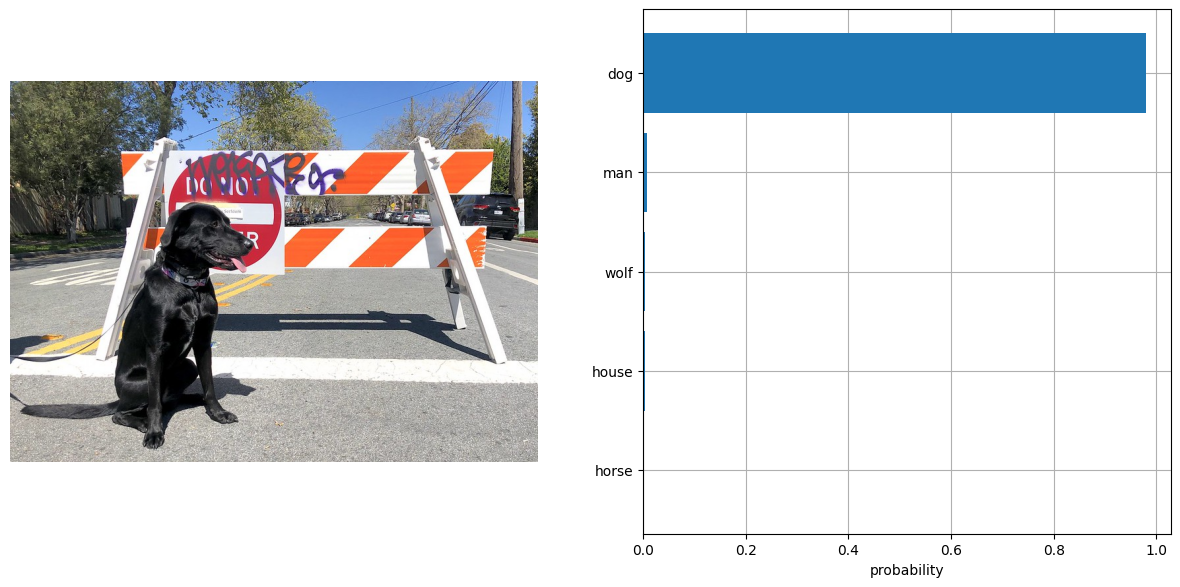

In [11]:
import numpy as np
from scipy.special import softmax
from openvino.runtime import compile_model
from visualize import visualize_result

image = Image.open('../data/image/coco.jpg')
input_labels = ['cat', 'dog', 'wolf', 'tiger', 'man', 'horse', 'frog', 'tree', 'house', 'computer']
text_descriptions = [f"This is a photo of a {label}" for label in input_labels]

inputs = processor(text=text_descriptions, images=[image], return_tensors="pt", padding=True)
compiled_model = compile_model(int8_model_path)
logits_per_image_out = compiled_model.output(0)
ov_logits_per_image = compiled_model(dict(inputs))[logits_per_image_out]
probs = softmax(ov_logits_per_image, axis=1)
visualize_result(image, input_labels, probs[0])

#### Compare File Size

In [15]:
from pathlib import Path

fp16_ir_model_size = Path(fp16_model_path).with_suffix(".bin").stat().st_size / 1024 / 1024
quantized_model_size = Path(int8_model_path).with_suffix(".bin").stat().st_size / 1024 / 1024
print(f"FP16 IR model size: {fp16_ir_model_size:.2f} MB")
print(f"INT8 model size: {quantized_model_size:.2f} MB")
print(f"Model compression rate: {fp16_ir_model_size / quantized_model_size:.3f}")

FP16 IR model size: 285.38 MB
INT8 model size: 168.14 MB
Model compression rate: 1.697


#### Compare inference time of the FP16 IR and quantized models
To measure the inference performance of the `FP16` and `INT8` models, we use median inference time on calibration dataset.
So we can approximately estimate the speed up of the dynamic quantized models.


> **NOTE**: For the most accurate performance estimation, it is recommended to run `benchmark_app` in a terminal/command prompt after closing other applications with static shapes.

In [13]:
import time
from openvino.runtime import compile_model

def calculate_inference_time(model_path, calibration_data):
    model = compile_model(model_path)
    output_layer = model.output(0)
    inference_time = []
    for batch in calibration_data:
        start = time.perf_counter()
        _ = model(batch)[output_layer]
        end = time.perf_counter()
        delta = end - start
        inference_time.append(delta)
    return np.median(inference_time)

In [14]:
fp16_latency = calculate_inference_time(fp16_model_path, calibration_data)
int8_latency = calculate_inference_time(int8_model_path, calibration_data)
print(f"Performance speed up: {fp16_latency / int8_latency:.3f}")

Performance speed up: 2.092
